# Part 3 -  Image Pre-processing

From the excellent notebook - https://www.kaggle.com/thomasjpfan/q-a-with-only-pictures it is also apparent that some images will need re-cropping.  

Note most of the image transformations used in this notebook are ammendments of code from this source so credit to the original creator thomasjpfan.

However before any of that I will have to read all of the images into numpy arrays.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pydicom

from rnsa_funcs import *

import os
import gc
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import util
from skimage import transform

import pickle

%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
#Setup path locations
BASE_PATH = 'G:\Kaggle\RSNA_Comp'
TRAIN_PATH_RAW = 'G:\Kaggle\RSNA_Comp\stage_1_train_images'
TEST_PATH_RAW = 'G:\Kaggle\RSNA_Comp\stage_1_test_images'
TRAIN_PATH_CLEAN = 'G:\Kaggle\RSNA_Comp\\train_image_clean'
TEST_PATH_CLEAN = 'G:\Kaggle\RSNA_Comp\\test_image_clean'

In [3]:
#Import dataframes from csvs
train_frame = pd.read_csv(os.path.join(TRAIN_PATH_CLEAN, 'train_frame.csv'))
val_1_frame = pd.read_csv(os.path.join(TRAIN_PATH_CLEAN, 'val_1_frame.csv'))
val_2_frame = pd.read_csv(os.path.join(TRAIN_PATH_CLEAN, 'val_2_frame.csv'))
test_frame = pd.read_csv(os.path.join(TEST_PATH_CLEAN, 'test_frame.csv'))

#Import train labels for drawing bounding boxes
train_labels = pd.read_csv(os.path.join(BASE_PATH, 'stage_1_train_labels.csv'))

Now the data is read in the next step is to read in every image and save them to a numpy array for further processing.

However in trying to do this the data is far larger than my computer is able to handle, even in the np.int8 format, therefore I will instead parse every image in the training data individually and do the training in an online fashion in batches.

So therefore in order to do this I will first have a look at some of the data.

Below is the original function I built to load all images into a dataframe, while the original purpose is a little redundant, it still can be used for having a look at some image batches.

In [4]:
def Import_Images(df, path):
    #Setup Variables
    m = df.shape[0]
    out_images = np.zeros((m, 1024, 1024), dtype=np.int16)

    for i in range(m) :
        filename = df['patientId'][i] + '.dcm'
        
        #Import full patient
        full_dicom = pydicom.read_file(os.path.join(path, filename))
        
        #Can subtract 128 to fit into the np.int8 format which has range -128 to 127
        #Original data in range 0-255
        img = full_dicom.pixel_array
    
        out_images[i] = img.astype(np.int16)
        
        del filename, full_dicom
        
        #Track progress
        if i % 1000 == 0 :
            print('Loaded file : ', i)
     
    gc.collect()
    return out_images
    

In [5]:
test_img_frm = val_1_frame.head(10)

In [6]:
test_img_arr = Import_Images(test_img_frm, TRAIN_PATH_RAW)

Loaded file :  0


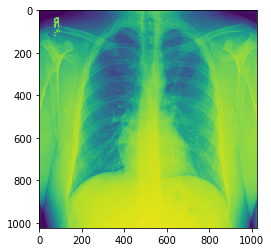

In [7]:
imgplot = plt.imshow(test_img_arr[1])

In [8]:
test_img_arr.max()

255

In [9]:
test_img_arr.min()

0

In [10]:
test_img_arr[1]

array([[ 4,  8,  8, ..., 14, 15,  7],
       [11, 16, 16, ..., 24, 25, 17],
       [ 9, 13, 14, ..., 23, 24, 16],
       ...,
       [14, 25, 22, ..., 85, 90, 53],
       [15, 26, 23, ..., 85, 93, 60],
       [ 6, 16, 13, ..., 42, 54, 27]], dtype=int16)

My initial intuition was to divide by 255 in order to allow a neural network to converge faster, however in scaling the data in this manner this will involve increasing the bit storage of the images and I simply do not have the memory to be able to store these full datasets in memory.

However now the logical path is to process each image one by one, and saving them as numpy arrays in the relevant subfolders.

## Image Cropping and Resizing

So as some of the images are clearly in need of some preprocessing to maximise the predictive power of a model, however there needs to be some consideration taken.  

Typical image preprocessing would do a crop and rotation of the images and then upscaling to the correct resolution, however this may not be appropriate here due to the evaluation metric.

As all bounding boxes are vertically aligned rectangles as per the data format, the outputs will also be vertically aligned rectangles.  As the evaluation metric is a composite of IOU measures for each positively identified bounding box this means that ANY rotation of a classifier has the potential to bias the output.  In order to avoid this NO rotations at all will be used.

Therefore to pre-process the images I will identify the null regions and crop and upscale the images accordingly.  It is also of paramount importance to save the mapping to easily translate from original image to modified and back for the bounding boxes.

For this reason any of the final holdout validation evaluation should be done on the original images and original bounding boxes as opposed to any generated distortions.  This is in order to accurately mimic the test set as closely as possible.

However for the classification problem this is not as much of an issue, so therefore a case may be made for having 2 seperate image sets - classifiers (with rotations permitted) and bounding boxes (with rotations forbidden).

In [11]:
#Take copy of the dataframe to investigate
test_bp = val_1_frame.copy()

In [12]:
test_bp.head(10)

,patientId,PatientsSex,PatientsAge,ViewPosition,PixelSpacing,Age_Band,Target_adv
0,a1055459-ab82-42b8-94f9-349a4ed5ec62,M,22,PA,0.143,"(18, 30]",0
1,d2022d4e-4224-4aac-ac5e-01ab4bd3792b,M,25,PA,0.168,"(18, 30]",0
2,c8565201-fcaa-41ed-8ed0-d8d5a2228fc6,F,46,AP,0.139,"(40, 50]",0
3,38d8647a-5c4c-43ae-8daf-73a21f2a4e4d,F,50,PA,0.168,"(40, 50]",0
4,e77dfc75-8bdd-4aee-967c-c7d97f9771f8,F,36,PA,0.143,"(30, 40]",0
5,e622bc6d-c39f-4c51-b51d-9acee5da80aa,M,22,AP,0.139,"(18, 30]",1
6,9c43a2f5-78a2-44fe-bbf4-de36283229e6,F,10,AP,0.171,"(0, 18]",1
7,6df43838-7da0-4236-9251-7d060f4a098b,M,51,AP,0.139,"(50, 60]",1
8,d3802bfc-9d15-4b63-814f-0d6aeaa505aa,M,52,AP,0.168,"(50, 60]",1
9,0ee29524-a273-4e20-a1fd-9df974be263e,F,21,AP,0.139,"(18, 30]",2


In [13]:
test_bp.shape

(1284, 7)

To achieve this I need to get some images to resize, taking the cue from the source I will take the images with a large amount of black pixels and start from there.

The first step is to get the images with a lot of black pixels, or a mean black pixel rate.

In [14]:
def import_mbps(df_in, path) : 
    df = df_in.copy()
    m = df.shape[0]
    df['mbp'] = 0.0
    
    for i in range(m) :
        #Read in file
        dcm_file = df['patientId'][i] + '.dcm'
        img_file = pydicom.read_file(os.path.join(path, dcm_file))
        img = img_file.pixel_array

        df['mbp'][i] = np.mean(img == 0)
        
        if i % 1000 == 0 :
             print('Loaded file : ', i)
    
    return df

In [15]:
bp_imgs = import_mbps(test_bp,TRAIN_PATH_RAW)

Loaded file :  0
Loaded file :  1000


In [16]:
bp_imgs.head(10)

,patientId,PatientsSex,PatientsAge,ViewPosition,PixelSpacing,Age_Band,Target_adv,mbp
0,a1055459-ab82-42b8-94f9-349a4ed5ec62,M,22,PA,0.143,"(18, 30]",0,0.093047
1,d2022d4e-4224-4aac-ac5e-01ab4bd3792b,M,25,PA,0.168,"(18, 30]",0,0.000000
2,c8565201-fcaa-41ed-8ed0-d8d5a2228fc6,F,46,AP,0.139,"(40, 50]",0,0.023109
3,38d8647a-5c4c-43ae-8daf-73a21f2a4e4d,F,50,PA,0.168,"(40, 50]",0,0.002431
4,e77dfc75-8bdd-4aee-967c-c7d97f9771f8,F,36,PA,0.143,"(30, 40]",0,0.017394
5,e622bc6d-c39f-4c51-b51d-9acee5da80aa,M,22,AP,0.139,"(18, 30]",1,0.001365
6,9c43a2f5-78a2-44fe-bbf4-de36283229e6,F,10,AP,0.171,"(0, 18]",1,0.050681
7,6df43838-7da0-4236-9251-7d060f4a098b,M,51,AP,0.139,"(50, 60]",1,0.003180
8,d3802bfc-9d15-4b63-814f-0d6aeaa505aa,M,52,AP,0.168,"(50, 60]",1,0.000255
9,0ee29524-a273-4e20-a1fd-9df974be263e,F,21,AP,0.139,"(18, 30]",2,0.014244


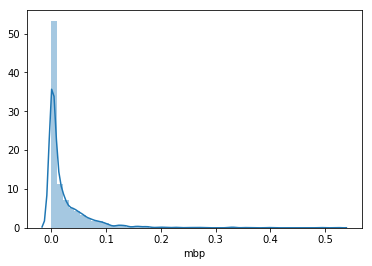

In [17]:
 ax = sns.distplot(bp_imgs['mbp'])

From this chart having a mpb of > 0.1 seemed like a good place to start, however these turned out to be simply darker images.  Taking a mbp of 0.2 seems to give the images that will need to be reshaped.

In [18]:
high_bp_imgs = bp_imgs[bp_imgs['mbp'] > 0.2]

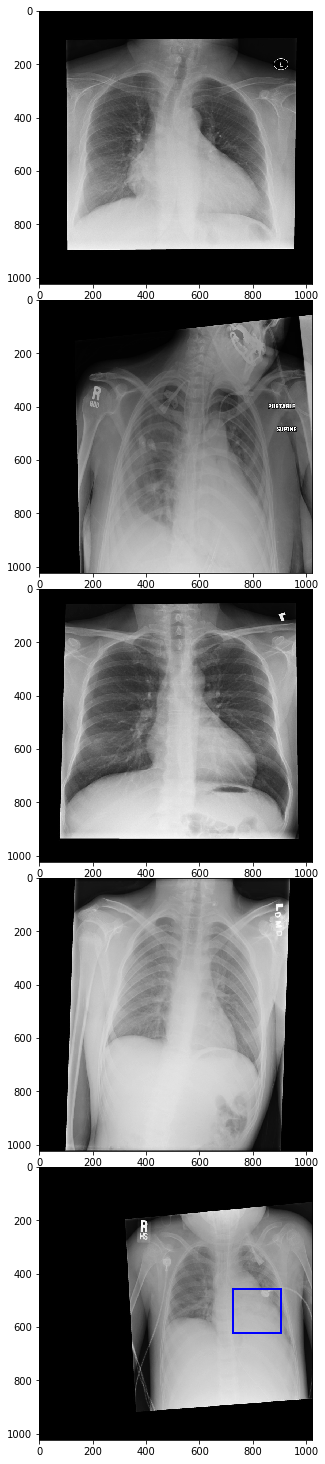

In [20]:
Drawimg_from_DF(high_bp_imgs.head(5), TRAIN_PATH_RAW, train_labels, 20)

In [21]:
high_bp_imgs.head(5)

,patientId,PatientsSex,PatientsAge,ViewPosition,PixelSpacing,Age_Band,Target_adv,mbp
83,49819189-845a-49ba-9f8a-d775ab939761,F,54,PA,0.139,"(50, 60]",1,0.355477
115,d3a9b9e6-7990-45e1-b914-b4c74fc41f9f,F,26,AP,0.168,"(18, 30]",1,0.227428
133,0a7b13a9-bcfe-4a99-b699-4c8cf6882f04,F,43,PA,0.139,"(40, 50]",0,0.260121
264,6fdfe34b-f264-4bec-8669-b19786a1a6e8,M,16,AP,0.168,"(0, 18]",0,0.211422
284,bca6d69c-5695-4660-bcc2-2e5f4e479135,M,13,AP,0.168,"(0, 18]",2,0.521642


From these the final image seems like a solid choice as that will also allow me to get the bounding box resizing working correctly also.

In [22]:
re_img_file = pydicom.read_file(os.path.join(TRAIN_PATH_RAW,'bca6d69c-5695-4660-bcc2-2e5f4e479135.dcm'))
resize_img = re_img_file.pixel_array
resize_bb = train_labels.loc[train_labels.patientId == 'bca6d69c-5695-4660-bcc2-2e5f4e479135', 
                                ['x', 'y', 'width', 'height']]

In [23]:
#Flattening values into numpy array to make it simpler to display
resize_bb_vals = np.squeeze(resize_bb.values)
resize_bb

,x,y,width,height
20681,725.0,458.0,179.0,165.0


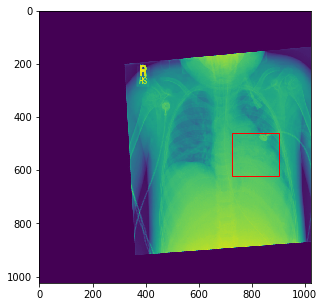

In [24]:
fig,ax = plt.subplots(1, figsize=(5,5))
ax.imshow(resize_img)
rect = patches.Rectangle((resize_bb_vals[0],resize_bb_vals[1]),resize_bb_vals[2],resize_bb_vals[3],
                         linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

Now we have a test image to work with let's resize it and modify the bounding box accordingly.

In [25]:
can_test = feature.canny(resize_img)

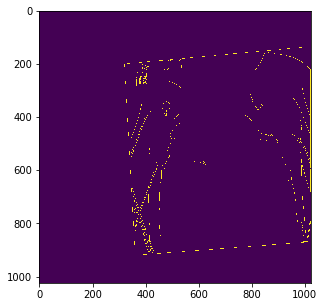

In [26]:
#plt.rc('figure', figsize=(20,20))
plt.figure(figsize=(5,5))
plt.imshow(can_test)

In [27]:
conv_hull = morphology.convex_hull_image(can_test)

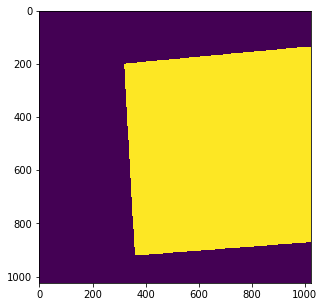

In [28]:
plt.figure(figsize=(5,5))
plt.imshow(conv_hull)

In [29]:
cont_find = measure.find_contours(conv_hull, 0)[0]
poly = measure.approximate_polygon(cont_find, 20)

In [30]:
poly

array([[ 920.,  371.],
       [ 199.,  320.],
       [ 133., 1022.],
       [ 869., 1023.],
       [ 920.,  371.]])

So here is where I will deviate from the original code which does a co-ordinate transform to a new 1024x1024 image from the calculated image.

The warp transformation estimates a distortion tensor to map each of the original coordinates to the new coordinates, this distortion is both stretching and rotating the image, however as previously discussed I wish to omit any rotations in order to avoid adding bias to the algorithm.  Hence I will normalize the coordinates to be symmetrical in x and y planes.  Thus meaning the warp transformation will not map any rotations and simply crop and stretch each axis independantly.

In [31]:
#Transformation without rotation
def transform_coordinates(coords):
    """Returns coordinates with order:
    (top left, top right, bottom right, bottom left)
    """
    coords = coords[:-1]
    output = np.empty((4, 2), dtype=np.float32)
    
    left = np.min(coords[:, 1])
    right = np.max(coords[:, 1])
    
    top = np.min(coords[:, 0])
    bottom = np.max(coords[:, 0])

    tl = (top, left)
    tr = (top, right)
    br = (bottom, right)
    bl = (bottom, left)
    
    output[0] = tl
    output[1] = tr
    output[2] = br
    output[3] = bl
    
    return output[:,::-1]

In [32]:
new_coords = transform_coordinates(poly)
orig_coords = np.array([[0, 0], [1024, 0], [1024, 1024], [0, 1024]])
print(new_coords)

[[ 320.  133.]
 [1023.  133.]
 [1023.  920.]
 [ 320.  920.]]


In [33]:
tform = transform.estimate_transform('projective', orig_coords, new_coords)
img_t = transform.warp(resize_img, tform, output_shape=(1024, 1024))

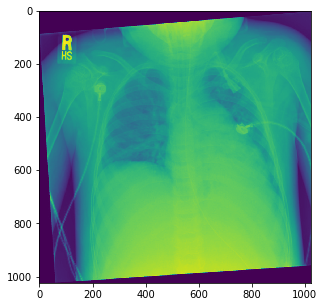

In [34]:
plt.figure(figsize=(5,5))
plt.imshow(img_t)

This looks much better, I realize it could be further improved by removing all of the black pixels, however this risks losing some data, also having the models trained on data with some slight data impurities will help in generate more generalizable results.

Now to calculate the bounding box transform and inverse transforms.

The inverse transform is not necessary for training, however for validation and testing this will be vital to transform the output of the model to fit the original image.

For the second validation set I will not be generating a transformed bounding box set, but will instead save the bounding box transforms.

In [35]:
def convert_bb(bb, tfm):
    x, y, w, h = bb[0], bb[1],bb[2],bb[3],
    pts = np.array([
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
    ])
    new_pts = tfm.inverse(pts)
    pts_min = np.min(new_pts, axis=0)
    pts_max = np.max(new_pts, axis=0)
    
    x, y = pts_min
    w, h = pts_max - pts_min
    
    return np.array([x, y, w, h])

In [36]:
new_bb = convert_bb(resize_bb_vals, tform)
new_bb

array([589.92887624, 422.87166455, 260.73399716, 214.68869123])

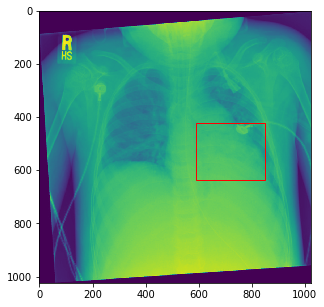

In [37]:
fig,ax = plt.subplots(1, figsize=(5,5))
ax.imshow(img_t)
rect = patches.Rectangle((new_bb[0],new_bb[1]),new_bb[2],new_bb[3],
                         linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

So the bounding box transformation seems like it requires no adjustments at all from the original code.

Next step is to generate an inverse transform from this to the original bounding box.

In [38]:
def invert_bb_convert(bb, tfm):
    x, y, w, h = bb[0], bb[1],bb[2],bb[3],
    pts = np.array([
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
    ])
    new_pts = tfm(pts)
    pts_min = np.min(new_pts, axis=0)
    pts_max = np.max(new_pts, axis=0)
    
    x, y = pts_min
    w, h = pts_max - pts_min
    
    return np.array([x, y, w, h])

In [39]:
recalc_bb = invert_bb_convert(new_bb, tform)

In [40]:
recalc_bb

array([725., 458., 179., 165.])

In [41]:
resize_bb_vals

array([725., 458., 179., 165.])

So a small modification and this works perfectly.

Now with all of the pieces tested let's put it all together and generate the training, validation and testing data for the models.

So the initial intuition was to store each of the images as numpy arrays and simply read them as and when I need them, however the raw uncompressed data for this is over 200Gb in storage, which is a little more than I am comfortable with.

Therefore to deal with this problem I will do the image transformations on reading each mini-batch, therefore I will simply create a function to read in a mini batch of images and transform them and output a numpy array ready to feed into a neural network.


As for the bounding boxes, it seems logical to simply generate these along with the training image array, and also output a dictionary of the transformation functions to do the inverse transform for the test/second validation sets.

In [94]:
#Function to do all of the data transformations tested above
def Cleanse_img(img) :
    #Generate image transformation
    can = feature.canny(img)
    conv_hull = morphology.convex_hull_image(can)
    cont_find = measure.find_contours(conv_hull, 0)[0]
    poly = measure.approximate_polygon(cont_find, 20)
    
    #Dependancy here on transform coordinates function
    new_coords = transform_coordinates(poly)
     
    orig_coords = np.array([[0, 0], [1024, 0], [1024, 1024], [0, 1024]])
    
    tform = transform.estimate_transform('projective', orig_coords, new_coords)
    
    #Output image
    img_t = transform.warp(img, tform, output_shape=(1024, 1024))
    
    return img_t, tform

In [95]:
def Clean_img_batch(df, inpath, outpath, test_flg = 0, label_df = None):
    #Setup Variables
    m = df.shape[0]
    out_img_batch = np.zeros((m, 1024, 1024))
    
    
    #Setup output dataframe for bounding boxes if needed
    if test_flg == 1 :
        transform_dict = {}
    else :
        out_label_df = label_df[0:0]
        
        #Generate One Hot array for classifier
        out_OH = pd.get_dummies(df.Target_adv, prefix='targ', dummy_na = False)
        out_label_OH = out_OH.values
    
    for i in range(m) :
        #Splitting patient id out for querying the labels
        patient_id = df['patientId'][i]
        in_filename = patient_id + '.dcm'
        out_filename = patient_id + '.npy'
        
        #Import patient data
        full_dicom = pydicom.read_file(os.path.join(inpath, in_filename))
        img = full_dicom.pixel_array
        
        #cleanse image data
        new_img, img_trans_func = Cleanse_img(img)
        
        #Transform image to normalize for model processing
        out_img_batch[i] = new_img / 255.0
        
        #Put transformation functions into dictionary if it is test set
        if test_flg == 1 :
            #Append personid to output transformation dictionary
            transform_dict[patient_id] = img_trans_func
            
        else :
            #Otherwise generate bounding box and save to dataframe
            
            #Get target
            has_bb = df['Target_adv'][i]
            
            #Check whether this has a bounding box
            if has_bb == 2:
                #Check that has label dataframe
                if label_df is None :
                    print('NO LABEL DATAFRAME')
                    break
                else :
                    pat_label = label_df.loc[label_df.patientId == patient_id, 
                                             ['x', 'y', 'width', 'height']].values
                    
                    #Get number of bounding boxes
                    n = pat_label.shape[0]
                    
                    #enumerate through bounding boxes and transform all
                    for j in range(n):
                        #Generate new bounding box
                        b_box = pat_label[j, :]
                        new_b_box = convert_bb(b_box, img_trans_func)
                        
                        #Create dataframe and append to output dataframe
                        box_dict = {'patientId' : patient_id, 
                                   'x' : new_b_box[0],
                                   'y' : new_b_box[1],
                                   'width' :new_b_box[2],
                                   'height' : new_b_box[3],
                                   'Target' : 1}
                        append_df = pd.DataFrame(data=box_dict, index=[0])
                        out_label_df = out_label_df.append(append_df, ignore_index=True)
                        
                        #Cleanup
                        del append_df, box_dict, b_box, new_b_box, n, pat_label
         
        #Cleanup for next pass
        del patient_id, in_filename, out_filename, full_dicom, img, new_img, img_trans_func

    gc.collect()
    if test_flg == 1 :
        return out_img_batch, transform_dict
    else :
        return out_img_batch, out_label_df, out_label_OH

In [44]:
test_sv = val_1_frame.tail(5).copy()
test_sv = test_sv.reset_index()
test_sv = test_sv.drop('index', axis=1)

In [45]:
test_sv

,patientId,PatientsSex,PatientsAge,ViewPosition,PixelSpacing,Age_Band,Target_adv
0,a74b7b44-ae2b-48cc-bc0a-597d221a4d08,F,8,AP,0.1943,"(0, 18]",1
1,f2f4c322-398b-4e19-826f-ec7303af2a69,F,16,AP,0.1390,"(0, 18]",1
2,3742349a-468e-464e-94a2-58f2af7b461f,M,17,AP,0.1680,"(0, 18]",0
3,5b2a5594-50f0-466c-8342-4b1396eaec37,M,59,AP,0.1390,"(50, 60]",1
4,38ac304d-c9bc-4056-9d15-e6290c2ca0e5,F,45,PA,0.1390,"(40, 50]",2


In [96]:
img_arr, labels, Y_OH = Clean_img_batch(test_sv, TRAIN_PATH_RAW, TRAIN_PATH_CLEAN, test_flg = 0, label_df = train_labels)

In [97]:
img_arr.shape

(5, 1024, 1024)

In [48]:
labels

,patientId,x,y,width,height,Target
0,38ac304d-c9bc-4056-9d15-e6290c2ca0e5,93.553128,363.816367,332.520357,358.706587,1


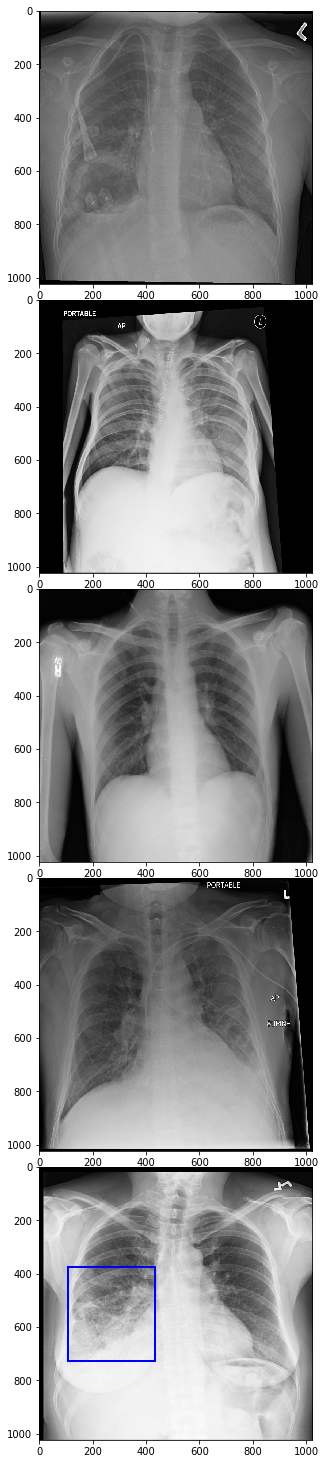

In [49]:
Drawimg_from_DF(test_sv, TRAIN_PATH_RAW, train_labels, 20)

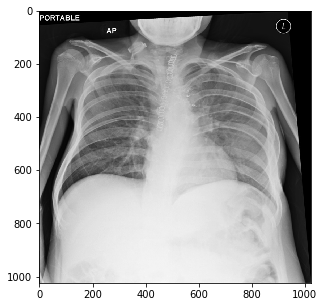

In [98]:
plt.figure(figsize=(5,5))
plt.imshow(img_arr[1], cmap='gray')

So it seems like this worked pretty well for generating training data, lets see how it works on generating an inverse transform for test data.

In [51]:
img_arr_tst, tf_dict = Clean_img_batch(test_sv, TRAIN_PATH_RAW, TRAIN_PATH_CLEAN, test_flg = 1, label_df = train_labels)

In [52]:
tf_dict

{'a74b7b44-ae2b-48cc-bc0a-597d221a4d08': <skimage.transform._geometric.ProjectiveTransform at 0x53df438>,
 'f2f4c322-398b-4e19-826f-ec7303af2a69': <skimage.transform._geometric.ProjectiveTransform at 0x53df748>,
 '3742349a-468e-464e-94a2-58f2af7b461f': <skimage.transform._geometric.ProjectiveTransform at 0x53dfa20>,
 '5b2a5594-50f0-466c-8342-4b1396eaec37': <skimage.transform._geometric.ProjectiveTransform at 0x53df6d8>,
 '38ac304d-c9bc-4056-9d15-e6290c2ca0e5': <skimage.transform._geometric.ProjectiveTransform at 0x53df518>}

In [53]:
#Patent = 38ac304d-c9bc-4056-9d15-e6290c2ca0e5
tst_bb = labels.drop(['patientId', 'Target'], axis=1)
tst_bb_val = np.squeeze(tst_bb.values)

In [54]:
tst_bb_val

array([ 93.5531281 , 363.81636727, 332.5203575 , 358.70658683])

In [55]:
#Perform inverse transform
tst_bb_orig = invert_bb_convert(tst_bb_val, tf_dict['38ac304d-c9bc-4056-9d15-e6290c2ca0e5'])
tst_bb_orig

array([107., 377., 327., 351.])

In [56]:
#Get data from original training labels
train_labels.loc[train_labels.patientId == '38ac304d-c9bc-4056-9d15-e6290c2ca0e5', 
                                             ['x', 'y', 'width', 'height']].values

array([[107., 377., 327., 351.]])

So now we have a set of functions to import and transform a minibatch of data as well as generate a transformed label dataset for both a bounding box generator and classifier.

Also in doing this the training schema for a final model has come more clearly into focus due to the limitations of my current hardware.  The next step is simply to create a minibatch generator to feed into this transformation function and start modelling.


### Tidied up functions + edits

Below here is a copy of the above functions but put into a logical order and tidied up a bit - for copying into a header file.

* Edit1 - added variable reassign to fix error in final function
* Edit2 - removed redundant input to function
* Edit3 - Changed pd.getdummies to manual OH array creation to account for small minibatches

In [ ]:
import os
import gc
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import util
from skimage import transform


def transform_coordinates(coords):
    """Returns coordinates with order:
    (top left, top right, bottom right, bottom left)
    """
    coords = coords[:-1]
    output = np.empty((4, 2), dtype=np.float32)
    
    left = np.min(coords[:, 1])
    right = np.max(coords[:, 1])
    
    top = np.min(coords[:, 0])
    bottom = np.max(coords[:, 0])

    tl = (top, left)
    tr = (top, right)
    br = (bottom, right)
    bl = (bottom, left)
    
    output[0] = tl
    output[1] = tr
    output[2] = br
    output[3] = bl
    
    return output[:,::-1]

def convert_bb(bb, tfm):
    x, y, w, h = bb[0], bb[1],bb[2],bb[3],
    pts = np.array([
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
    ])
    new_pts = tfm.inverse(pts)
    pts_min = np.min(new_pts, axis=0)
    pts_max = np.max(new_pts, axis=0)
    
    x, y = pts_min
    w, h = pts_max - pts_min
    
    return np.array([x, y, w, h])



def invert_bb_convert(bb, tfm):
    x, y, w, h = bb[0], bb[1],bb[2],bb[3],
    pts = np.array([
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
    ])
    new_pts = tfm(pts)
    pts_min = np.min(new_pts, axis=0)
    pts_max = np.max(new_pts, axis=0)
    
    x, y = pts_min
    w, h = pts_max - pts_min
    
    return np.array([x, y, w, h])



def Cleanse_img(img) :
    #Generate image transformation
    can = feature.canny(img)
    conv_hull = morphology.convex_hull_image(can)
    cont_find = measure.find_contours(conv_hull, 0)[0]
    poly = measure.approximate_polygon(cont_find, 20)
    
    #Dependancy here on transform coordinates function
    new_coords = transform_coordinates(poly)
    orig_coords = np.array([[0, 0], [1024, 0], [1024, 1024], [0, 1024]])
    
    tform = transform.estimate_transform('projective', orig_coords, new_coords)
    
    #Output image
    img_t = transform.warp(img, tform, output_shape=(1024, 1024))
    
    return img_t, tform



def Clean_img_batch(df, inpath, test_flg = 0, label_df = None):
    #Setup Variables
    m = df.shape[0]
    out_img_batch = np.zeros((m, 1024, 1024))
    
    
    #Setup output dataframe for bounding boxes if needed
    if test_flg == 1 :
        transform_dict = {}
    else :
        out_label_df = label_df[0:0]
        
        #Generate One Hot array for classifier
        out_oh = pd.DataFrame()
        out_oh['tar_0'] = df['Target_adv'].map( {0: 1, 1: 0, 2:0 } ).astype(int)
        out_oh['tar_1'] = df['Target_adv'].map( {0: 0, 1: 1, 2:0 } ).astype(int)
        out_oh['tar_2'] = df['Target_adv'].map( {0: 0, 1: 0, 2:1 } ).astype(int)
        out_label_OH = out_oh.values
    
    for i in range(m) :
        #Splitting patient id out for querying the labels
        patient_id = df['patientId'][i]
        in_filename = patient_id + '.dcm'
        out_filename = patient_id + '.npy'
        
        #Import patient data
        full_dicom = pydicom.read_file(os.path.join(inpath, in_filename))
        img = full_dicom.pixel_array
        
        #cleanse image data
        new_img, img_trans_func = Cleanse_img(img)
        
        #Transform image to normalize for model processing
        out_img_batch[i] = new_img / 255.0
        
        #Put transformation functions into dictionary if it is test set
        if test_flg == 1 :
            #Append personid to output transformation dictionary
            transform_dict[patient_id] = img_trans_func
            
        else :
            #Otherwise generate bounding box and save to dataframe
            
            #Get target
            has_bb = df['Target_adv'][i]
            
            #Check whether this has a bounding box
            if has_bb == 2:
                #Check that has label dataframe
                if label_df is None :
                    print('NO LABEL DATAFRAME')
                    break
                else :
                    pat_label = label_df.loc[label_df.patientId == patient_id, 
                                             ['x', 'y', 'width', 'height']].values
                    
                    #Get number of bounding boxes
                    n = pat_label.shape[0]

                    #enumerate through bounding boxes and transform all
                    for j in range(n):
                        #Was getting odd error of variable referenced before assignment so reassigning here
                        pat_label = label_df.loc[label_df.patientId == patient_id, 
                                             ['x', 'y', 'width', 'height']].values
                        #Generate new bounding box
                        b_box = pat_label[j, :]
                        new_b_box = convert_bb(b_box, img_trans_func)
                        
                        #Create dataframe and append to output dataframe
                        box_dict = {'patientId' : patient_id, 
                                   'x' : new_b_box[0],
                                   'y' : new_b_box[1],
                                   'width' :new_b_box[2],
                                   'height' : new_b_box[3],
                                   'Target' : 1}
                        append_df = pd.DataFrame(data=box_dict, index=[0])
                        out_label_df = out_label_df.append(append_df, ignore_index=True)
                        
                        
                        #Cleanup
                        del append_df, box_dict, b_box, new_b_box, pat_label
         
        #Cleanup for next pass
        del patient_id, in_filename, out_filename, full_dicom, img, new_img, img_trans_func, has_bb

    gc.collect()
    if test_flg == 1 :
        return out_img_batch, transform_dict
    else :
        return out_img_batch, out_label_df, out_label_OH



